In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [2]:
from pathlib import Path
import copy
import logging
import sys

sys.path.insert(0, "ema_limit")
from qat import get_params, get_transducer_model, load_checkpoint_if_available, get_parser

from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
from torch import nn
import torchao
import sentencepiece as spm
from lhotse.cut import CutSet
from lhotse.utils import LOG_EPSILON
import k2
from icefall.utils import add_sos
from icefall.lexicon import Lexicon
from icefall.utils import write_error_stats

from model import Transducer
from asr_datamodule import AsrDataModule

Skipping import of cpp extensions due to incompatible torch version 2.9.0+cu129 for torchao version 0.14.0         Please see GitHub issue #2919 for more info


In [7]:
x = torch.load("exp/en/qat/a8w4/batch-8dea3aa4-c08a-6073-52d0-95151c4a09ca.pt", map_location="cpu", weights_only=False)

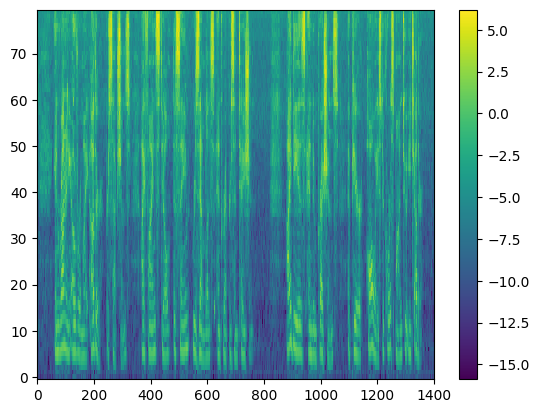

In [8]:
mel = x["inputs"][2].transpose(0,1)
im = plt.imshow(mel.cpu().numpy(), origin='lower', interpolation='nearest', aspect='auto')
plt.colorbar(im)
plt.show()

In [4]:
parser = get_parser()
AsrDataModule.add_arguments(parser)
args = parser.parse_args([
    '--channels', '256',
    '--channels-expansion', '1024',
    '--dilations-version', '11',
    '--kernel-size', '8',
    '--encoder-dropout', '0.075',
    '--encoder-activation', 'ReLU',
    '--encoder-se-activation', 'ReLU',
    '--encoder-norm', 'BatchNorm',
    '--decoder-dim', '256',
    '--joiner-dim', '256',
    '--act-bal', 'False',
    '--whitener', 'False',
    '--scale-limit', '2.0',
    '--ema-gamma', '0.97',  
    '--chunksize', '8',
    '--n-bits-act', '8',
    '--n-bits-weight', '8',
    '--bpe-model', "data/en/lang_bpe_500/bpe.model",
    '--start-epoch', '7',
    '--exp-dir', 'exp/en/qat/a8w4',
    '--data-libri-train', 'True',
    '--data-libri-test-clean', 'True',
    '--manifest-dir', 'data/en/fbank',
])

In [5]:
args.exp_dir = Path(args.exp_dir)
params = get_params()
params.update(vars(args))

sp = spm.SentencePieceProcessor()
sp.load(params.bpe_model)
params.blank_id = sp.piece_to_id("<blk>")
params.unk_id = sp.piece_to_id("<unk>")
params.vocab_size = sp.get_piece_size()
logging.basicConfig(
    format="%(asctime)s %(levelname)s [%(filename)s:%(lineno)d] %(message)s",
    level=logging.INFO
)

In [9]:
model = get_transducer_model(params)
load_checkpoint_if_available(params, model)

for name, params in model.named_parameters():
    assert torch.all(torch.isfinite(params)), name

2025-12-12 19:28:49,282 INFO [checkpoint.py:112] Loading checkpoint from exp/en/qat/a8w4/epoch-6.pt
2025-12-12 19:28:49,406 INFO [checkpoint.py:131] Loading averaged model


In [17]:
feature = x["inputs"]
feature_len = x["supervisions"]["num_frames"]

encoder_out, *_ = model.encoder(feature, feature_len)

In [21]:
encoder_out.abs().max()

tensor(16.1961, grad_fn=<MaxBackward1>)